In [11]:
using Revise
using Plots
using MultiScales
using ITensors
import LinearAlgebra: I
ITensors.set_warn_order(1000)

newaxis = [CartesianIndex()]

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

In [2]:
nbits = [2, 4, 6, 8, 10]
bondims = Int[]
for nbit in nbits
    N = 2^nbit
    sites = siteinds("Qubit", nbit)
    M = MultiScales._qft(sites)
    push!(bondims, maximum(collect(size(m)[1] for m in M)))
end

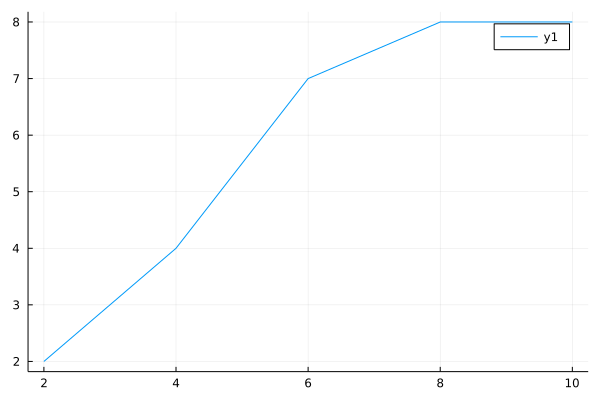

In [3]:
plot(nbits, bondims)

In [4]:
N = 4
sites = siteinds("Qubit",N)

4-element Vector{Index{Int64}}:
 (dim=2|id=847|"Qubit,Site,n=1")
 (dim=2|id=617|"Qubit,Site,n=2")
 (dim=2|id=543|"Qubit,Site,n=3")
 (dim=2|id=720|"Qubit,Site,n=4")

In [5]:
_delta(i, j) = Int(i == j)

# Note: NOT type stable
function _phasegate(nphase::Int, position)
    ϕ = π * 0.5^(nphase-1)
    _exp(x, k) = exp(-im * ϕ * (x-1) * (k-1))
    if position == :center
        arr = zeros(ComplexF64, 2, 2, 2, 2)
        for x in 1:2, k in 1:2
            arr[k,x,x,k] = _exp(x, k)
        end
        return arr
    elseif position == :left
        arr = zeros(ComplexF64, 2, 2, 2)
        for x in 1:2, k in 1:2
            arr[x,k,k] = _exp(x, k)
        end
        return arr
    elseif position == :right
        arr = zeros(ComplexF64, 2, 2, 2)
        for x in 1:2, k in 1:2
            arr[k,x,k] = _exp(x, k)
        end
        return arr
    elseif position == :only
        arr = zeros(ComplexF64, 1, 2, 2)
        for x in 1:2, k in 1:2
            arr[1,x,k] = _exp(x, k)
        end
        return arr
    else
        error("Invalid position")
    end
end

_phasegate (generic function with 1 method)

In [6]:
# Note: NOT type stable
function _identitygate(position)
    arr = Matrix{ComplexF64}(I, 2, 2)
    if position == :center
        return reshape(arr, (1,2,2,1))
    elseif position == :left
        return reshape(arr, (2,2,1))
    else
        error("Invalid position")
    end
end

_identitygate (generic function with 1 method)

In [7]:
function _assign!(M::MPO, n::Int, arr; autoreshape=false)
    if autoreshape
        arr = reshape(arr, map(dim, inds(M[n]))...)
    end
    M[n] = ITensor(arr, inds(M[n])...)
    return nothing
end

function _phasegates(sites, ntargetbits)
    N = length(sites)
    offset = length(sites) - ntargetbits
    M = MultiScales._zero_mpo(sites; linkdims=vcat(ones(Int,offset), fill(2,N-1-offset)))

    # I gate
    for n in 1:offset
        pos = (n == 1) ? :left : :center
        _assign!(M, n, _identitygate(pos))
    end

    # Phase gates
    if ntargetbits == 1
        _assign!(M, 1 + offset, _phasegate(1, :only))
    else
        _assign!(M, 1 + offset, _phasegate(1, :left))
        for i in 2:(ntargetbits-1)
            _assign!(M, i + offset, _phasegate(i, :center))
        end
        _assign!(M, ntargetbits + offset, _phasegate(ntargetbits, :right))
    end
    return M
end

_phasegates (generic function with 1 method)

In [12]:
function _qft(sites; kwargs...)
    M = _phasegates(sites, 1)
    for layer in 2:length(sites)
        M = apply(_phasegates(sites, layer), M; kwargs...)
    end
    return M
end
_qft(sites)

MPO
[1] ((dim=2|id=89|"Qubit,Site,n=1")', (dim=2|id=89|"Qubit,Site,n=1"), (dim=2|id=483|"Link,n=1"))
[2] ((dim=2|id=435|"Qubit,Site,n=2")', (dim=2|id=435|"Qubit,Site,n=2"), (dim=4|id=239|"Link,n=2"), (dim=2|id=483|"Link,n=1"))
[3] ((dim=2|id=223|"Qubit,Site,n=3")', (dim=2|id=223|"Qubit,Site,n=3"), (dim=4|id=926|"Link,n=3"), (dim=4|id=239|"Link,n=2"))
[4] ((dim=2|id=660|"Qubit,Site,n=4")', (dim=2|id=660|"Qubit,Site,n=4"), (dim=4|id=926|"Link,n=3"))


In [22]:
Ns = [4, 8, 12, 16, 20]
_maxlinkdim(M) = maximum(maximum(map(dim, inds(m; tags="Link"))) for m in M)
bonddims = Int[]
cutoff = 1e-20
for N in Ns
    sites = siteinds("Qubit", N)
    M = _qft(sites; cutoff=1e-30)
    truncate!(M; cutoff=cutoff)
    push!(bonddims, _maxlinkdim(M))
end
bonddims

5-element Vector{Int64}:
  4
 16
 28
 26
 24

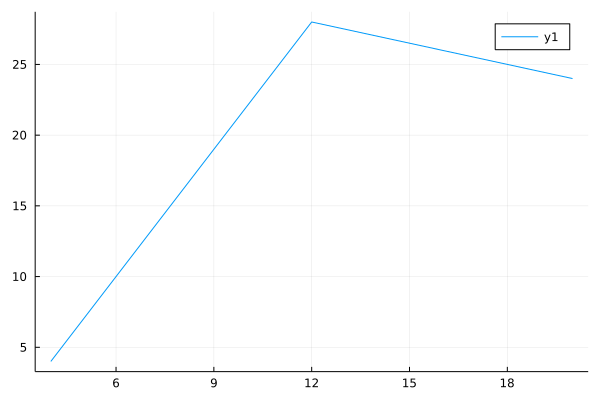

In [23]:
plot(Ns, bonddims)